# Example of Image Processing

In this notebook we will use scikit-image is a collection of algorithms for image processing in Python (http://scikit-image.org/)

We will:
* load a picture from file
* separate foreground and background
* identify interesting objects
* use an object for template search

These tasks consistute the basis for ML image processing.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.measure import regionprops

from skimage import io
from skimage import transform, color
from skimage.feature import match_template



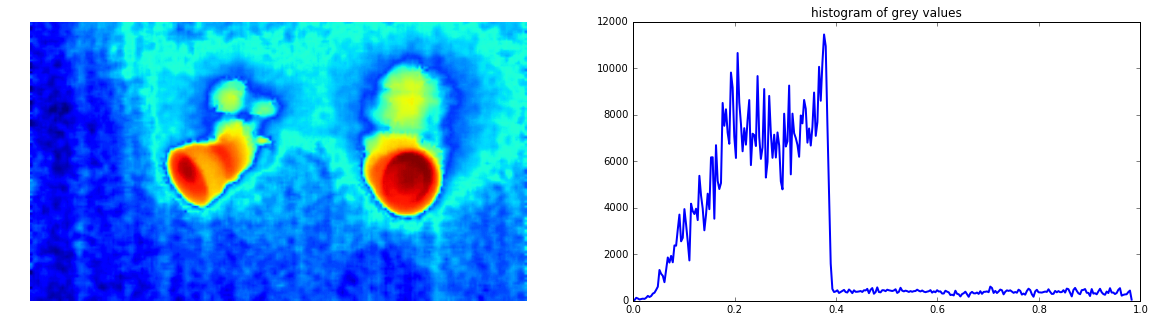

In [2]:
# Load an image
image = io.imread("./img_thermal_1463123877274.jpg")

# return the luminance of an image 
img = color.rgb2gray(image)

# Create an histogram with the grey values and show it together with the grey scale image
histo = np.histogram(img, bins=300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax1.imshow(img)
ax1.axis('off')
ax2.plot(histo[1][:-1], histo[0], lw=2)
ax2.set_title('histogram of grey values')


### The Otsu's method 

In computer vision and image processing, Otsu's method, is used to automatically perform clustering-based image thresholding, or the reduction of a graylevel image to a binary image. 

The algorithm assumes that the image contains two classes of pixels (foreground pixels and background pixels), it then calculates the optimum threshold separating the two classes.

(more info in https://en.wikipedia.org/wiki/Otsu%27s_method)

This is the threshold which best separate fore- and back-ground:  0.492469162071


(-0.5, 1107.5, 623.5, -0.5)

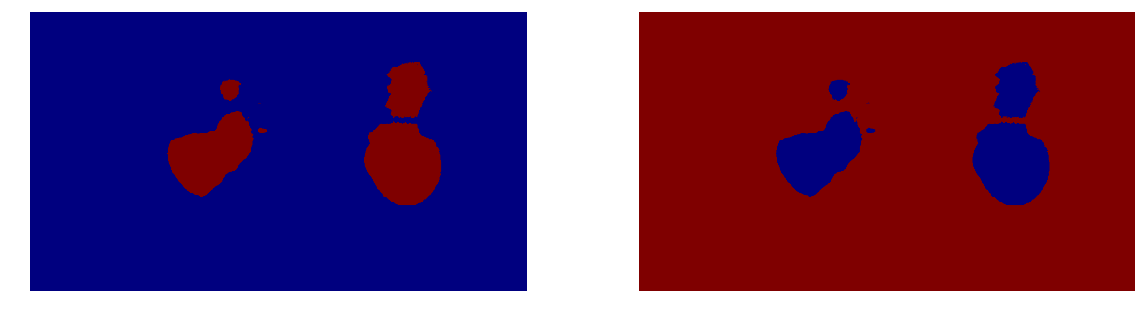

In [3]:
# apply threshold to better separate objects from the background

thresh = threshold_otsu(img)

print "This is the threshold which best separate fore- and back-ground: ", thresh

# Define the fore- and back-ground image according to the threshold level

foreimg = img>thresh
backimg = img<thresh

# Display the fore- and back-ground images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.imshow(foreimg)
ax1.axis('off')
ax2.imshow(backimg)
ax2.axis('off')



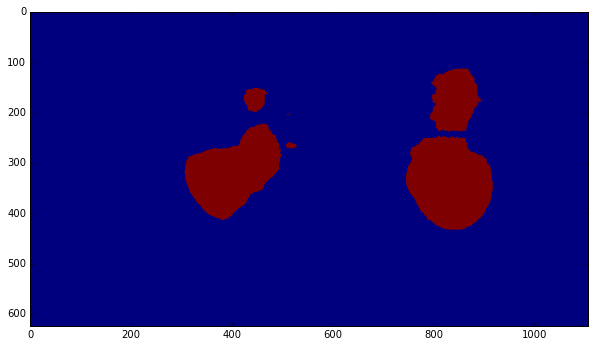

In [4]:
# To help the following processes let us apply some closing.
# Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. 
# This tends to “close” up (dark) gaps between (bright) features.

bw = closing(img > thresh, square(3))

# then let us also remove artifacts connected to image border

cleared = bw.copy()
clear_border(cleared)
# Print the cleared image
plt.figure(figsize=(10,10))
plt.imshow(cleared)

region idx =  3  area =  21745
region idx =  5  area =  24431


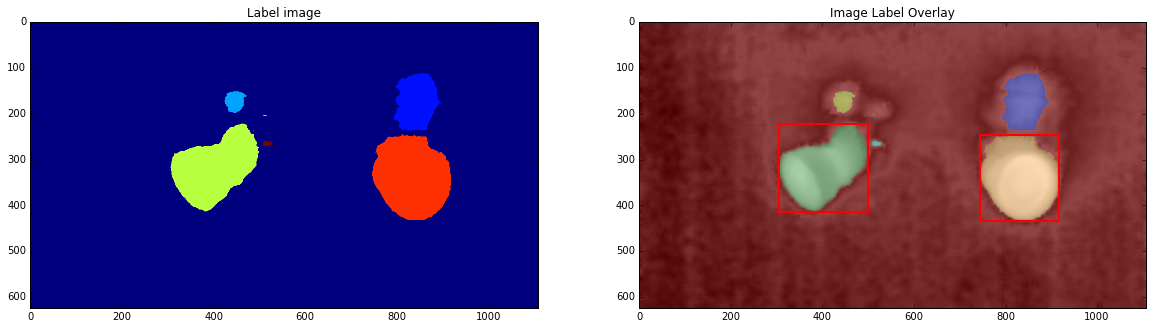

The largest region idx is  5 and has area =  24431


In [5]:
# label image regions

# Two pixels are connected when they are neighbors and have the same value
label_image = label(cleared)

borders = np.logical_xor(bw, cleared)
label_image[borders] = -1

#Return an RGB image where color-coded labels are painted over the image.
image_label_overlay = color.label2rgb(label_image, image=img)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 20))
ax1.set_title("Label image")
ax1.imshow(label_image)
ax2.set_title("Image Label Overlay")
ax2.imshow(image_label_overlay)

# Define the minimum area the object must have to be considered
min_area = 10000
max_area = -9999
idx_area = -9
counter  = -1
# regionprops: Measure properties of labeled image regions

for region in regionprops(label_image):
    counter = counter+1 
    # skip small images
    if region.area < min_area:
        continue

    print "region idx = ", counter, " area = ", region.area
    if region.area>max_area:
        max_area = region.area
        idx_area = counter
    
    # draw a red rectangle around the recognised objects
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax2.add_patch(rect)

plt.show()
print "The largest region idx is ", idx_area, "and has area = ", max_area

## Template mathing

In the following we wil use template matching to identify the occurrence of an image patch (a sub-image defined from the found objects)


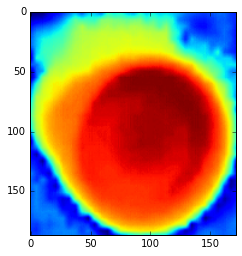

In [6]:
# Use one of the two largest regions for template definition

idx = idx_area # you can change this according to your wich, for example to 3

# retrieve the region properties
region =  (regionprops(label_image)[idx])


# define the template to be searched for
minr, minc, maxr, maxc = region.bbox
templ = img[minr:maxr, minc:maxc]
plt.imshow(templ)


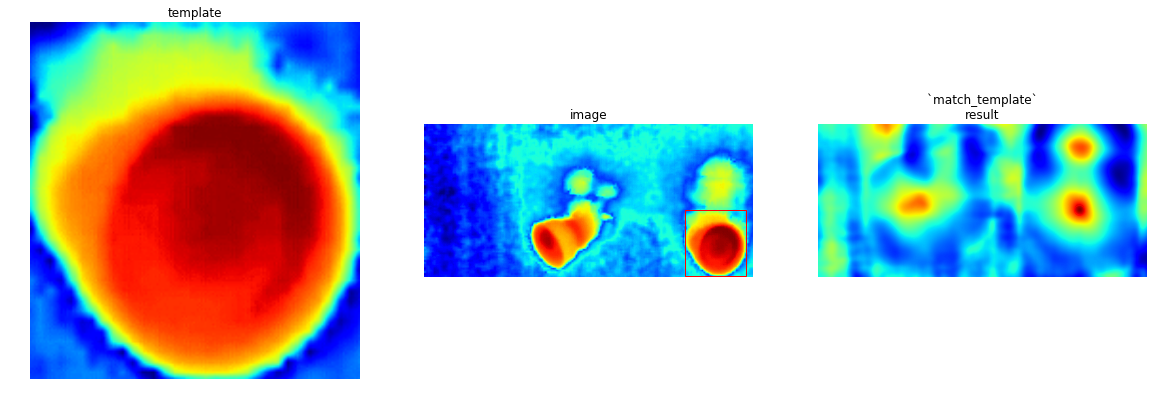

In [7]:
# Find back the template from the original image
result = match_template(img, templ)
ij = np.unravel_index(np.argmax(result), result.shape)
#x, y = ij[::-1]
y,x=ij

fig = plt.figure(figsize=(20, 20))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2, adjustable='box-forced')

ax1.imshow(templ)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(img)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
htempl, wtempl = templ.shape
rect = plt.Rectangle((x, y), wtempl, htempl, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

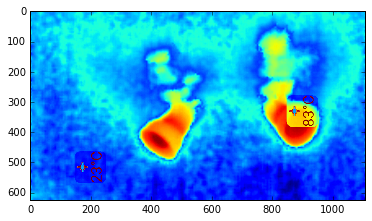

In [8]:
# let us see if we can find the same pattern in another image
# just choose one of the following two
#image2 = io.imread("./img_tp_thermal_1463123829544.jpg")
image2 = io.imread("./img_tp_thermal_1463123833305.jpg")

img2 = color.rgb2gray(image2)
plt.imshow(img2)


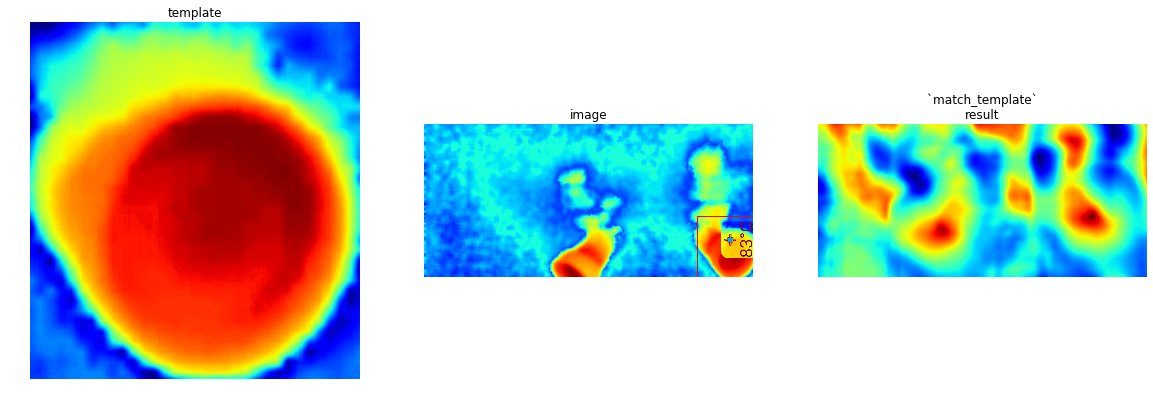

In [9]:
# Find back the template from the original image
result = match_template(img2, templ)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]
y,x=ij

fig = plt.figure(figsize=(20, 20))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2, adjustable='box-forced')

ax1.imshow(templ)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(img2)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
htempl, wtempl = templ.shape
rect = plt.Rectangle((x, y), wtempl, htempl, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()